<h1 style="color:yellow;">Concurrent Data - Machine Learning</h1>

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
from utils import print_evaluation_metrics, log_metrics, plot_individual_metrics, preprocessing

# Load the dataframes

In [2]:

# 1. Define the directory where your data is saved
save_dir = os.path.join('..', 'data frames', 'main', 'MLP2', 'PCA_0.99')

X_train = pd.read_csv(os.path.join(save_dir, 'X_train_PCA_0.99.csv'))
X_val = pd.read_csv(os.path.join(save_dir, 'X_val_PCA_0.99.csv'))
X_test = pd.read_csv(os.path.join(save_dir, 'X_test_PCA_0.99.csv'))

# 3. Load the target vectors (y)
# Use .values.ravel() to convert the DataFrame to a 1D array (expected for labels)
y_train = pd.read_csv(os.path.join(save_dir, 'y_train_PCA_0.99.csv')).values.ravel()
y_val = pd.read_csv(os.path.join(save_dir, 'y_val_PCA_0.99.csv')).values.ravel()
y_test = pd.read_csv(os.path.join(save_dir, 'y_test_PCA_0.99.csv')).values.ravel()

# 4. Load the label encoder classes
label_classes = np.load(os.path.join(save_dir, 'label_classes_PCA_0.99.npy'), allow_pickle=True)

print("All datasets loaded successfully.")

All datasets loaded successfully.


In [3]:
from sklearn.preprocessing import LabelEncoder

# Reconstruct the encoder from the saved classes
output_encoder = LabelEncoder()
output_encoder.classes_ = label_classes
output_encoder.fit(label_classes) # Sometimes needed to initialize internal dicts

print(f"Encoder restored. Classes: {output_encoder.classes_}")

Encoder restored. Classes: ['Benign' 'HTTPFlood' 'ICMPFlood' 'SYNFlood' 'SYNScan' 'SlowrateDoS'
 'TCPConnectScan' 'UDPFlood' 'UDPScan']


# Arguments

In [4]:
sampling_method = 'hybrid_100k'
version = sampling_method + '_Optuna' + 'PCA99'
plot_distributions = True
model_results= []
results_dir = os.path.join('figures', version, 'results')
evaluation_dir = os.path.join('figures', version, 'evaluatoin charts')

# Process the dataframes

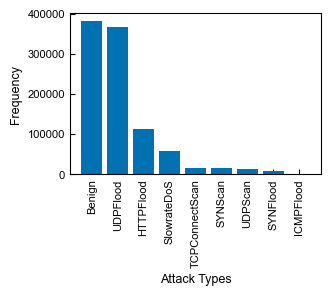

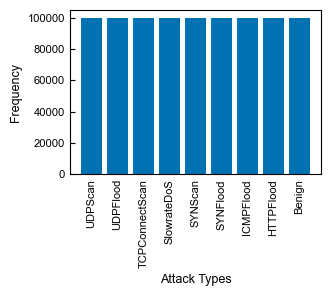


[Preprocessing] Final dataset sizes (after hybrid_100k):
  - Training samples: 900000
  - Validation samples: 121587
  - Test samples: 121587


In [5]:
X_train_proc, X_val_proc, X_test_proc, y_train_proc, y_val_proc, y_test_proc = preprocessing(
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        output_encoder,
        evaluation_dir,       # Pass save_dir here so plots (like class dist) save to the specific folder
        version, 
        sampling_method, 
        plot_distributions
    )

# Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.utils.class_weight import compute_sample_weight
import optuna
from sklearn.metrics import f1_score


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Logistic Regression

Logistic Regression Evaluation:
Accuracy: 0.89162493
Precision: 0.92498602
Recall: 0.89162493
F1 Score: 0.90376187
Training Time: 52.2274 seconds
Prediction Time: 0.0048 seconds
latency per sample: 0.00000004 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.95615598 0.88653520 0.92003038     47821
     HTTPFlood  0.95161514 0.97959184 0.96540084     14014
     ICMPFlood  0.20538721 1.00000000 0.34078212       122
      SYNFlood  0.89189189 0.87352941 0.88261516      1020
       SYNScan  0.99739312 0.95268924 0.97452878      2008
   SlowrateDoS  0.92075472 0.94704741 0.93371600      7214
TCPConnectScan  0.81283644 0.99695277 0.89552920      1969
      UDPFlood  0.91374132 0.85042259 0.88094565     45789
       UDPScan  0.23702624 0.99754601 0.38303887      1630

      accuracy                      0.89162493    121587
     macro avg  0.76520023 0.94270161 0.79739856    121587
  weighted avg  0.92498602 0.89162493 0.90376187    1

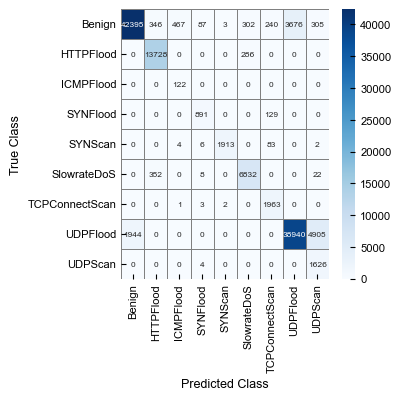

In [10]:
linear_model = LogisticRegression(solver='saga', max_iter=1000, random_state=42, class_weight='balanced')

start_time = time.time()
linear_model.fit(X_train_proc, y_train_proc)
training_time = time.time() - start_time

start_time = time.time()
y_pred_lr = linear_model.predict(X_val_proc)
prediction_time = time.time() - start_time

# arguments for evaluation function
results_file_name = 'logistic_regression_results.txt'
cm_title = 'Logistic Regression Confusion Matrix'

print("Logistic Regression Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_proc, y_pred_lr, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'LR', accuracy, precision, recall, f1, training_time, prediction_time)

## Random Forest

[I 2026-02-03 15:00:22,971] A new study created in memory with name: no-name-0216509b-0a92-4a94-bcc5-7823c923187e


Optimizing Random Forest with Optuna...


[I 2026-02-03 15:00:55,504] Trial 0 finished with value: 0.9846779163816095 and parameters: {'n_estimators': 148, 'max_depth': 43, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9846779163816095.
[I 2026-02-03 15:01:22,142] Trial 1 finished with value: 0.9843980625308613 and parameters: {'n_estimators': 130, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9846779163816095.
[I 2026-02-03 15:02:06,741] Trial 2 finished with value: 0.9844889215531228 and parameters: {'n_estimators': 212, 'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9846779163816095.
[I 2026-02-03 15:02:43,201] Trial 3 finished with value: 0.9827106619699957 and parameters: {'n_estimators': 202, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9846779163816095.
[I 2026-02-03 15:03:20,907] Trial 4 finished with value: 0.9815959902669993 and parameters:

Best Random Forest Params: {'n_estimators': 273, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 2}
Random Forest (Optuna) Evaluation:
Accuracy: 0.98536028
Precision: 0.98552130
Recall: 0.98536028
F1 Score: 0.98536098
Training Time: 56.5290 seconds
Prediction Time: 0.1936 seconds
latency per sample: 0.00000159 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99244478 0.97239706 0.98231864     47821
     HTTPFlood  0.99636234 0.99678893 0.99657559     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99804305 1.00000000 0.99902057      1020
       SYNScan  0.99750623 0.99601594 0.99676053      2008
   SlowrateDoS  0.99334812 0.99362351 0.99348579      7214
TCPConnectScan  0.99796851 0.99796851 0.99796851      1969
      UDPFlood  0.97195482 0.99226889 0.98200681     45789
       UDPScan  0.99693627 0.99815951 0.99754752      1630

      accuracy                      0.98536028    12

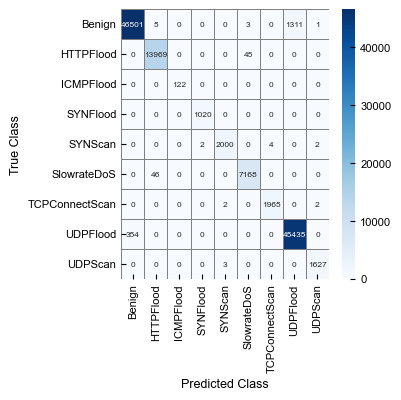

In [ ]:
def objective_rf(trial):
    # 1. Define the search space
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # 2. Initialize model with trial parameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    
    # 3. Train
    clf.fit(X_train_proc, y_train_proc)
    
    # 4. Evaluate (Maximize F1 Weighted)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val_proc, y_pred, average='weighted')
    return score

# Create Study and Optimize
print("Optimizing Random Forest with Optuna...")
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=40) # Increase n_trials (e.g., 50 or 100) for better results

print("Best Random Forest Params:", study_rf.best_params)

# Train Final Model with Best Params
best_params_rf = study_rf.best_params
rnd_forest = RandomForestClassifier(
    **best_params_rf,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

start_time = time.time()
rnd_forest.fit(X_train_proc, y_train_proc)
training_time = time.time() - start_time

start_time = time.time()
y_pred_rf = rnd_forest.predict(X_val_proc)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'random_forest_optuna_results.txt'
cm_title = 'Random Forest (Optuna) Confusion Matrix'

print("Random Forest (Optuna) Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_proc, y_pred_rf, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'RF', accuracy, precision, recall, f1, training_time, prediction_time)


## XGBoost

[I 2026-02-03 15:32:43,157] A new study created in memory with name: no-name-8cc43d4a-94d4-4d75-8ed8-9e478e65c495


Optimizing XGBoost with Optuna...


[I 2026-02-03 15:32:54,345] Trial 0 finished with value: 0.9839130687964772 and parameters: {'n_estimators': 267, 'max_depth': 4, 'learning_rate': 0.20820523022783688, 'subsample': 0.9264463197549986, 'colsample_bytree': 0.5803704097736448, 'reg_alpha': 5.481905605248706e-05, 'reg_lambda': 0.015513855661773117}. Best is trial 0 with value: 0.9839130687964772.
[I 2026-02-03 15:33:05,117] Trial 1 finished with value: 0.982580194790997 and parameters: {'n_estimators': 195, 'max_depth': 6, 'learning_rate': 0.029990232924472636, 'subsample': 0.66878128407201, 'colsample_bytree': 0.8666108969744325, 'reg_alpha': 1.2731105527056732e-07, 'reg_lambda': 1.0027695102978681e-07}. Best is trial 0 with value: 0.9839130687964772.
[I 2026-02-03 15:33:12,898] Trial 2 finished with value: 0.984151877325692 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.16263328635891744, 'subsample': 0.9884644013125718, 'colsample_bytree': 0.9712938479272479, 'reg_alpha': 0.005609291472191481, 

Best XGBoost Params: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.16263328635891744, 'subsample': 0.9884644013125718, 'colsample_bytree': 0.9712938479272479, 'reg_alpha': 0.005609291472191481, 'reg_lambda': 6.523825891536841e-07}
XGBoost (Optuna) Evaluation:
Accuracy: 0.98415127
Precision: 0.98451615
Recall: 0.98415127
F1 Score: 0.98415188
Training Time: 7.6456 seconds
Prediction Time: 0.1668 seconds
latency per sample: 0.00000137 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99598844 0.96568453 0.98060242     47821
     HTTPFlood  0.99657681 0.99714571 0.99686118     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99804305 1.00000000 0.99902057      1020
       SYNScan  0.99800300 0.99551793 0.99675891      2008
   SlowrateDoS  0.99431503 0.99403937 0.99417718      7214
TCPConnectScan  0.99695586 0.99796851 0.99746193      1969
      UDPFlood  0.96538877 0.99595973 0.98043600  

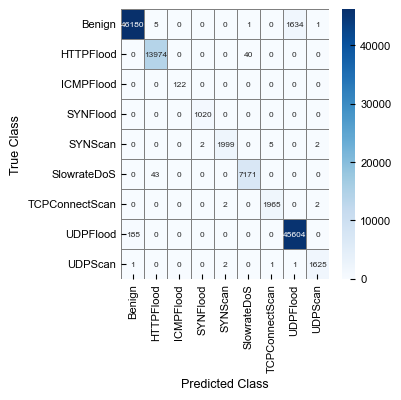

In [ ]:
# Pre-compute sample weights once to save time inside the loop
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_proc)

def objective_xgb(trial):
    # 1. Define search space
    params = {
        'objective': 'multi:softmax',
        'num_class': len(output_encoder.classes_),
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }
    
    # 2. Initialize model
    clf = xgb.XGBClassifier(**params)
    
    # 3. Train (using sample weights)
    clf.fit(X_train_proc, y_train_proc, sample_weight=sample_weights)
    
    # 4. Evaluate
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val_proc, y_pred, average='weighted')
    return score

# Create Study and Optimize
print("Optimizing XGBoost with Optuna...")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=40) # Increase n_trials for better results

print("Best XGBoost Params:", study_xgb.best_params)

# Train Final Model with Best Params
best_params_xgb = study_xgb.best_params
# Re-add fixed parameters that aren't in best_params
best_params_xgb.update({
    'objective': 'multi:softmax',
    'num_class': len(output_encoder.classes_),
    'eval_metric': 'mlogloss',
    'n_jobs': -1,
    'random_state': 42
})

xgb_model = xgb.XGBClassifier(**best_params_xgb)

start_time = time.time()
xgb_model.fit(X_train_proc, y_train_proc, sample_weight=sample_weights)
training_time = time.time() - start_time

start_time = time.time()
y_pred_xgb = xgb_model.predict(X_val_proc)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'xgboost_optuna_results.txt'
cm_title = 'XGBoost (Optuna) Confusion Matrix'

print("XGBoost (Optuna) Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_proc, y_pred_xgb, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'XGB', accuracy, precision, recall, f1, training_time, prediction_time)

## Naive Bayes

Naive Bayes Evaluation:
Accuracy: 0.71515047
Precision: 0.80929835
Recall: 0.71515047
F1 Score: 0.71304070
Training Time: 0.0775 seconds
Prediction Time: 0.0192 seconds
latency per sample: 0.00000016 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.98768537 0.55849940 0.71352622     47821
     HTTPFlood  0.89542012 0.53153989 0.66708458     14014
     ICMPFlood  0.99186992 1.00000000 0.99591837       122
      SYNFlood  0.50199886 0.86176471 0.63442800      1020
       SYNScan  0.51404277 0.99352590 0.67753439      2008
   SlowrateDoS  0.50335570 0.90449127 0.64677603      7214
TCPConnectScan  0.99378882 0.08125952 0.15023474      1969
      UDPFlood  0.67522661 0.90615650 0.77383017     45789
       UDPScan  0.27513138 0.99570552 0.43113295      1630

      accuracy                      0.71515047    121587
     macro avg  0.70427995 0.75921586 0.63227394    121587
  weighted avg  0.80929835 0.71515047 0.71304070    121587



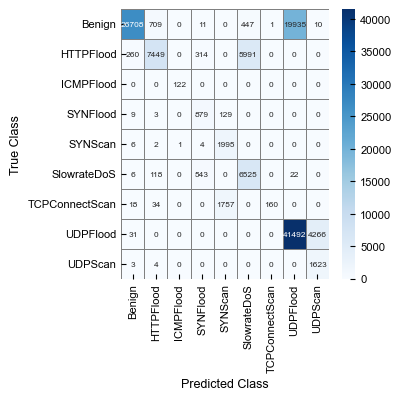

In [13]:
# Create a Naive Bayes classifier
nb_model = GaussianNB()

# Train the model
start_time = time.time()
nb_model.fit(X_train_proc, y_train_proc)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_nb = nb_model.predict(X_val_proc)
prediction_time = time.time() - start_time

# arguments for evaluation function
results_file_name = 'naive_bayes_results.txt'
cm_title = 'Naive Bayes Confusion Matrix'

print("Naive Bayes Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_proc, y_pred_nb, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'NB', accuracy, precision, recall, f1, training_time, prediction_time)

## SVM

Training One-vs-Rest Linear SVM (Calibrated)...
Predicting...
SVM (Linear OvR) Evaluation:
Accuracy: 0.94648277
Precision: 0.94723771
Recall: 0.94648277
F1 Score: 0.94658211
Training Time: 145.3369 seconds
Prediction Time: 0.0869 seconds
latency per sample: 0.00000071 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.93658043 0.94776353 0.94213880     47821
     HTTPFlood  0.95100681 0.95711431 0.95405079     14014
     ICMPFlood  0.97600000 1.00000000 0.98785425       122
      SYNFlood  0.99028183 0.99901961 0.99463153      1020
       SYNScan  0.98861386 0.99452191 0.99155909      2008
   SlowrateDoS  0.87962255 0.95619629 0.91631243      7214
TCPConnectScan  0.89070295 0.99746064 0.94106373      1969
      UDPFlood  0.96704093 0.93297517 0.94970266     45789
       UDPScan  0.95867769 0.99631902 0.97713598      1630

      accuracy                      0.94648277    121587
     macro avg  0.94872523 0.97570783 0.96160547    

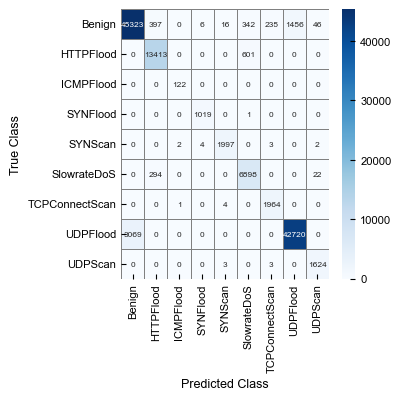

In [14]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
import time

# 1. Define Linear SVM
# dual=False is generally preferred when n_samples > n_features.
linear_svc = LinearSVC(dual=False, random_state=42, max_iter=200000, class_weight='balanced')

# 2. Wrap in CalibratedClassifierCV to enable predict_proba
# This is required for the model to be compatible with a soft-voting ensemble.
calibrated_svc = CalibratedClassifierCV(estimator=linear_svc, method='sigmoid', cv=3)

# 3. Wrap in OneVsRestClassifier
# n_jobs=4 uses 4 CPU cores to train the per-class models in parallel.
ovr_classifier = OneVsRestClassifier(estimator=calibrated_svc, n_jobs=4)

# Train
print("Training One-vs-Rest Linear SVM (Calibrated)...")
start_time = time.time()
ovr_classifier.fit(X_train_proc, y_train_proc)
training_time = time.time() - start_time

# Predict
print("Predicting...")
start_time = time.time()
y_pred_svm = ovr_classifier.predict(X_val_proc)
prediction_time = time.time() - start_time

# Arguments for evaluation
results_file_name = 'svm_linear_ovr_results.txt'
cm_title = 'SVM (Linear OvR) Confusion Matrix'

print("SVM (Linear OvR) Evaluation:")
# Ensure print_evaluation_metrics and log_metrics are available from utils.py
accuracy, precision, recall, f1 = print_evaluation_metrics(
    y_val_proc, y_pred_svm, training_time, prediction_time, 
    output_encoder, results_dir, version, results_file_name, cm_title
)

# Log metrics
log_metrics(model_results, 'SVM', accuracy, precision, recall, f1, training_time, prediction_time)


## KNN

Training k-NN ...
Predicting k-NN ...
k-NN Evaluation:
Accuracy: 0.98378116
Precision: 0.98379861
Recall: 0.98378116
F1 Score: 0.98377960
Training Time: 0.0526 seconds
Prediction Time: 21.4706 seconds
latency per sample: 0.00017659 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.98445105 0.97708120 0.98075228     47821
     HTTPFlood  0.99479055 0.99471957 0.99475506     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99804305 1.00000000 0.99902057      1020
       SYNScan  0.99700599 0.99501992 0.99601196      2008
   SlowrateDoS  0.98786876 0.99334627 0.99059994      7214
TCPConnectScan  0.99594526 0.99796851 0.99695586      1969
      UDPFlood  0.97716033 0.98388259 0.98050994     45789
       UDPScan  0.99754902 0.99877301 0.99816064      1630

      accuracy                      0.98378116    121587
     macro avg  0.99253489 0.99342123 0.99297403    121587
  weighted avg  0.98379861 0.9

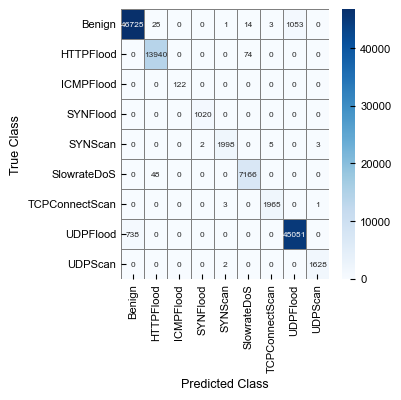

In [15]:
# Create k-NN classifier
# n_neighbors=5 is standard. n_jobs=-1 is CRITICAL for speed.
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Train
print("Training k-NN ...")
start_time = time.time()
knn_model.fit(X_train_proc, y_train_proc)
training_time = time.time() - start_time

# Predict
# WARNING: k-NN is slow at prediction time!
print("Predicting k-NN ...")
start_time = time.time()
y_pred_knn = knn_model.predict(X_val_proc)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'knn_results.txt'
cm_title = 'k-NN Confusion Matrix'

print("k-NN Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_proc, y_pred_knn, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'KNN', accuracy, precision, recall, f1, training_time, prediction_time)

## Decision Tree

Training Decision Tree...
Predicting...
Decision Tree Evaluation:
Accuracy: 0.98310675
Precision: 0.98310495
Recall: 0.98310675
F1 Score: 0.98310551
Training Time: 18.0953 seconds
Prediction Time: 0.0061 seconds
latency per sample: 0.00000005 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.98022475 0.97952782 0.97987616     47821
     HTTPFlood  0.99507565 0.99493364 0.99500464     14014
     ICMPFlood  0.98387097 1.00000000 0.99186992       122
      SYNFlood  0.99512195 1.00000000 0.99755501      1020
       SYNScan  0.99701195 0.99701195 0.99701195      2008
   SlowrateDoS  0.98977618 0.99306903 0.99141987      7214
TCPConnectScan  0.99796851 0.99796851 0.99796851      1969
      UDPFlood  0.97932179 0.97949289 0.97940733     45789
       UDPScan  0.99877074 0.99693252 0.99785078      1630

      accuracy                      0.98310675    121587
     macro avg  0.99079361 0.99321515 0.99199602    121587
  weighted avg  0.9

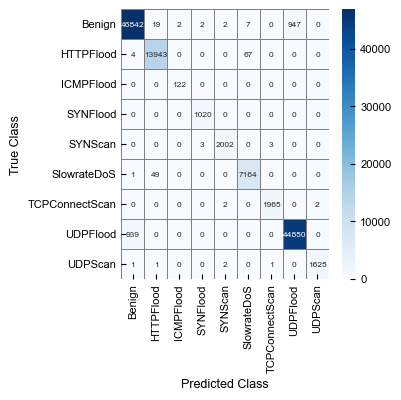

In [16]:
# Create Decision Tree
# max_depth=None means it grows fully (can overfit). 
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Train
print("Training Decision Tree...")
start_time = time.time()
dt_model.fit(X_train_proc, y_train_proc)
training_time = time.time() - start_time

# Predict
print("Predicting...")
start_time = time.time()
y_pred_dt = dt_model.predict(X_val_proc)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'decision_tree_results.txt'
cm_title = 'Decision Tree Confusion Matrix'

print("Decision Tree Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_proc, y_pred_dt, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'DT', accuracy, precision, recall, f1, training_time, prediction_time)

## MLP

Training MLP Classifier...
Iteration 1, loss = 0.06332389
Iteration 2, loss = 0.03199329
Iteration 3, loss = 0.03034569
Iteration 4, loss = 0.02774480
Iteration 5, loss = 0.02660962
Iteration 6, loss = 0.02559714
Iteration 7, loss = 0.02535447
Iteration 8, loss = 0.02462579
Iteration 9, loss = 0.02426704
Iteration 10, loss = 0.02392363
Iteration 11, loss = 0.02338495
Iteration 12, loss = 0.02325807
Iteration 13, loss = 0.02296588
Iteration 14, loss = 0.02289089
Iteration 15, loss = 0.02289526
Iteration 16, loss = 0.02250861
Iteration 17, loss = 0.02256754
Iteration 18, loss = 0.02253857
Iteration 19, loss = 0.02220838
Iteration 20, loss = 0.02221763
Iteration 21, loss = 0.02221913
Iteration 22, loss = 0.02214335
Iteration 23, loss = 0.02192933
Iteration 24, loss = 0.02202319
Iteration 25, loss = 0.02204463
Iteration 26, loss = 0.02189485
Iteration 27, loss = 0.02194097
Iteration 28, loss = 0.02182651
Iteration 29, loss = 0.02203624
Iteration 30, loss = 0.02163889
Iteration 31, loss = 0

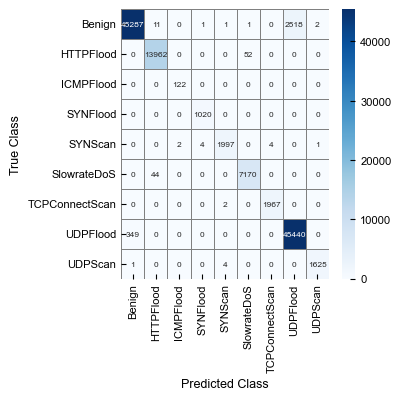

In [17]:
# Create MLP (Shallow Neural Network)
# hidden_layer_sizes=(100, 50) means 2 layers. max_iter=300 ensures convergence.
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 96, 64, 48), max_iter=300, random_state=42, activation='relu', solver='adam', alpha=0.005, verbose=True)

print("Training MLP Classifier...")
start_time = time.time()
mlp_model.fit(X_train_proc, y_train_proc)
training_time = time.time() - start_time

print("Predicting...")
start_time = time.time()
y_pred_mlp = mlp_model.predict(X_val_proc)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'mlp_results.txt'
cm_title = 'MLP Classifier Confusion Matrix'

print("MLP Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_proc, y_pred_mlp, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'MLP', accuracy, precision, recall, f1, training_time, prediction_time)

## LDA

Training LDA...
Predicting...
LDA Evaluation:
Accuracy: 0.81804798
Precision: 0.87376111
Recall: 0.81804798
F1 Score: 0.83834796
Training Time: 0.3522 seconds
Prediction Time: 0.0035 seconds
latency per sample: 0.00000003 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.91467036 0.76010539 0.83025548     47821
     HTTPFlood  0.95928790 0.93820465 0.94862915     14014
     ICMPFlood  0.04222915 1.00000000 0.08103620       122
      SYNFlood  0.32000000 0.86274510 0.46684350      1020
       SYNScan  0.99899194 0.98705179 0.99298597      2008
   SlowrateDoS  0.86356340 0.82034932 0.84140186      7214
TCPConnectScan  0.84568966 0.99644490 0.91489858      1969
      UDPFlood  0.83918855 0.81851536 0.82872305     45789
       UDPScan  0.24296828 0.99631902 0.39066635      1630

      accuracy                      0.81804798    121587
     macro avg  0.66962103 0.90885950 0.69949335    121587
  weighted avg  0.87376111 0.81804798 0.

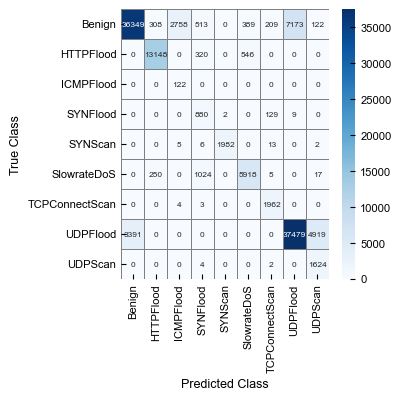

In [18]:
# Create LDA
lda_model = LinearDiscriminantAnalysis()

print("Training LDA...")
start_time = time.time()
lda_model.fit(X_train_proc, y_train_proc)
training_time = time.time() - start_time

print("Predicting...")
start_time = time.time()
y_pred_lda = lda_model.predict(X_val_proc)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'lda_results.txt'
cm_title = 'LDA Confusion Matrix'

print("LDA Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_proc, y_pred_lda, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'LDA', accuracy, precision, recall, f1, training_time, prediction_time)

## Voting Classifier

Training Voting Classifier (Ensemble)...
Iteration 1, loss = 0.06332389
Iteration 2, loss = 0.03199329
Iteration 3, loss = 0.03034569
Iteration 4, loss = 0.02774480
Iteration 5, loss = 0.02660962
Iteration 6, loss = 0.02559714
Iteration 7, loss = 0.02535447
Iteration 8, loss = 0.02462579
Iteration 9, loss = 0.02426704
Iteration 10, loss = 0.02392363
Iteration 11, loss = 0.02338495
Iteration 12, loss = 0.02325807
Iteration 13, loss = 0.02296588
Iteration 14, loss = 0.02289089
Iteration 15, loss = 0.02289526
Iteration 16, loss = 0.02250861
Iteration 17, loss = 0.02256754
Iteration 18, loss = 0.02253857
Iteration 19, loss = 0.02220838
Iteration 20, loss = 0.02221763
Iteration 21, loss = 0.02221913
Iteration 22, loss = 0.02214335
Iteration 23, loss = 0.02192933
Iteration 24, loss = 0.02202319
Iteration 25, loss = 0.02204463
Iteration 26, loss = 0.02189485
Iteration 27, loss = 0.02194097
Iteration 28, loss = 0.02182651
Iteration 29, loss = 0.02203624
Iteration 30, loss = 0.02163889
Iteratio

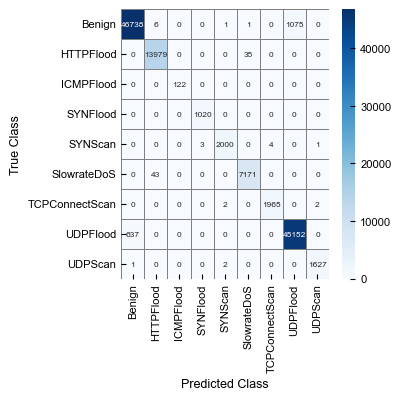

In [19]:
# 1. Define the models to combine (Estimators)
# We use the models you've already defined above (make sure to run their cells first!)
estimators = [
    ('rf', rnd_forest),
    ('xgb', xgb_model),
    ('svm', ovr_classifier),
    ('knn', knn_model),
    ('dt', dt_model),
    ('mlp', mlp_model)
]

# 2. Create Voting Classifier
# voting='soft' averages the probabilities (usually better). 'hard' counts votes.
voting_model = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

print("Training Voting Classifier (Ensemble)...")
start_time = time.time()
voting_model.fit(X_train_proc, y_train_proc)
training_time = time.time() - start_time

print("Predicting...")
start_time = time.time()
y_pred_voting = voting_model.predict(X_val_proc)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'voting_ensemble_results.txt'
cm_title = 'Voting Ensemble Confusion Matrix'

print("Voting Ensemble Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_proc, y_pred_voting, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'VC', accuracy, precision, recall, f1, training_time, prediction_time)


Training Stacking Classifier...
Note: This will take significantly longer than VotingClassifier as it trains models multiple times for CV.
Iteration 1, loss = 0.06332389
Iteration 2, loss = 0.03199329
Iteration 3, loss = 0.03034569
Iteration 4, loss = 0.02774480
Iteration 5, loss = 0.02660962
Iteration 6, loss = 0.02559714
Iteration 7, loss = 0.02535447
Iteration 8, loss = 0.02462579
Iteration 9, loss = 0.02426704
Iteration 10, loss = 0.02392363
Iteration 11, loss = 0.02338495
Iteration 12, loss = 0.02325807
Iteration 13, loss = 0.02296588
Iteration 14, loss = 0.02289089
Iteration 15, loss = 0.02289526
Iteration 16, loss = 0.02250861
Iteration 17, loss = 0.02256754
Iteration 18, loss = 0.02253857
Iteration 19, loss = 0.02220838
Iteration 20, loss = 0.02221763
Iteration 21, loss = 0.02221913
Iteration 22, loss = 0.02214335
Iteration 23, loss = 0.02192933
Iteration 24, loss = 0.02202319
Iteration 25, loss = 0.02204463
Iteration 26, loss = 0.02189485
Iteration 27, loss = 0.02194097
Iterat

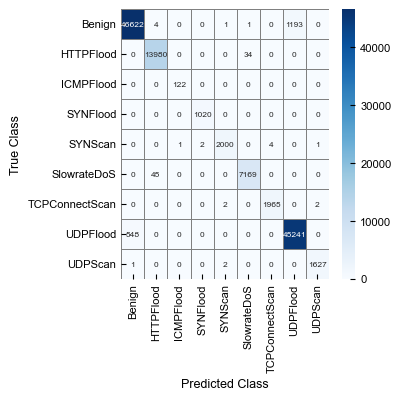

In [20]:


# 1. Define the base estimators
# We use the models you've already defined and tuned in previous cells.
estimators = [
    ('rf', rnd_forest),
    ('xgb', xgb_model),
    ('svm', ovr_classifier),
    ('knn', knn_model),
    ('dt', dt_model),
    ('mlp', mlp_model),
    ('lda', lda_model)
]

# 2. Create Stacking Classifier
# final_estimator: The model that aggregates the predictions. LogisticRegression is standard.
# cv=3: Uses 3-fold cross-validation to generate the training data for the meta-learner.
# n_jobs=-1: Parallelizes the training of base estimators during CV.
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=3,
    n_jobs=-1,
    passthrough=False # Set to True if you want to feed original features to the meta-learner as well
)

print("Training Stacking Classifier...")
print("Note: This will take significantly longer than VotingClassifier as it trains models multiple times for CV.")
start_time = time.time()
stacking_model.fit(X_train_proc, y_train_proc)
training_time = time.time() - start_time

print("Predicting...")
start_time = time.time()
y_pred_stacking = stacking_model.predict(X_val_proc)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'stacking_classifier_results.txt'
cm_title = 'Stacking Classifier Confusion Matrix'

print("Stacking Classifier Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(
    y_val_proc, y_pred_stacking, training_time, prediction_time, 
    output_encoder, results_dir, version, results_file_name, cm_title
)

# Log metrics
log_metrics(model_results, 'Stacking', accuracy, precision, recall, f1, training_time, prediction_time)


# Bar charts

Saved hybrid_100k_OptunaPCA99_comparison_accuracy.png


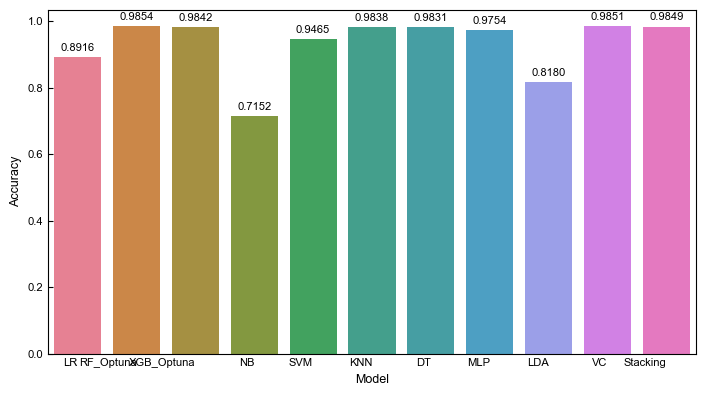

Saved hybrid_100k_OptunaPCA99_comparison_precision.png


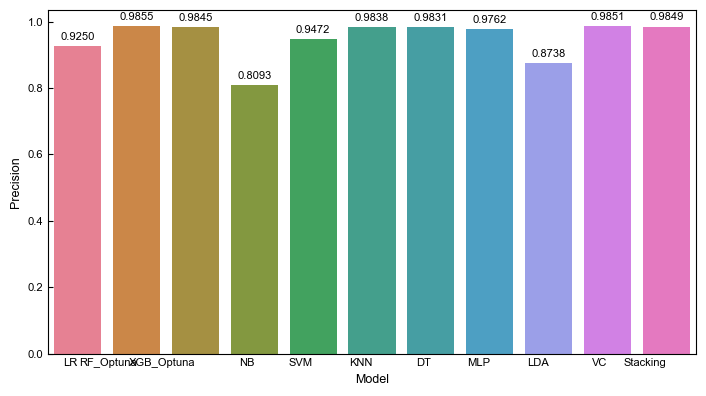

Saved hybrid_100k_OptunaPCA99_comparison_recall.png


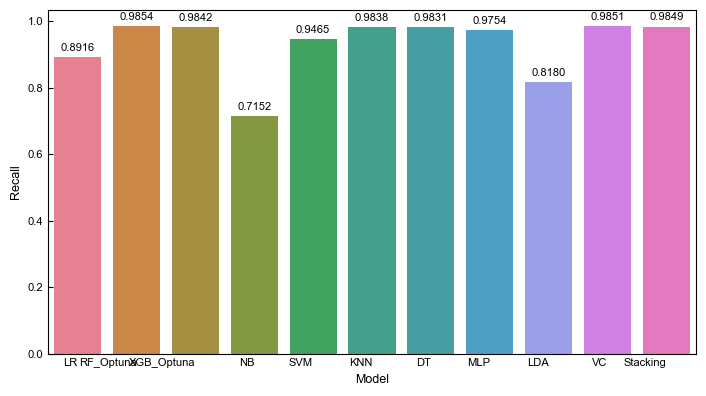

Saved hybrid_100k_OptunaPCA99_comparison_f1-score.png


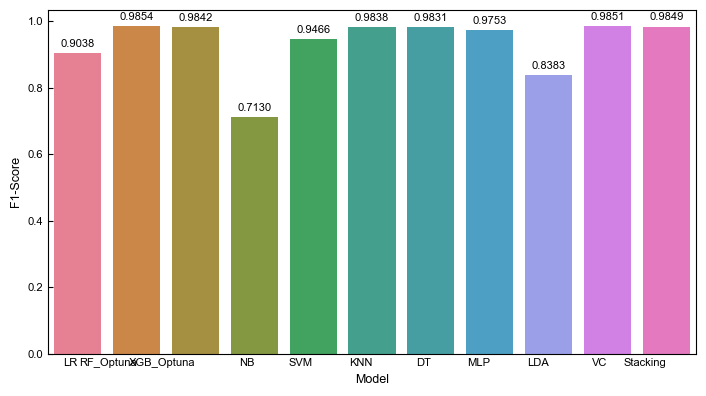

Saved hybrid_100k_OptunaPCA99_comparison_training_time_s.png


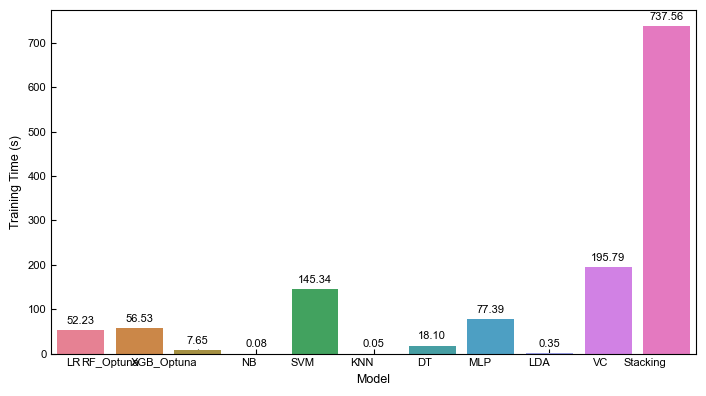

Saved hybrid_100k_OptunaPCA99_comparison_prediction_time_s.png


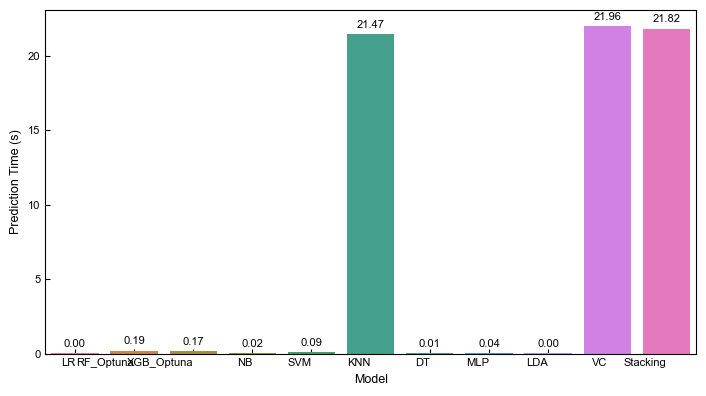

In [21]:
plot_individual_metrics(model_results, evaluation_dir, version)